In [3]:
#########################
# Goal of this code is to generate Fig. 2 in my paper (lag regression figure of KW precip, x: lon, y: lag day)
# 2023.12.22
# Mu-Ting Chien
#########################################

In [4]:
import numpy as np
from numpy import dtype
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from sklearn import linear_model

In [5]:
DIR = '/glade/work/muting/'
CASENAME_LIST2 = list(['SST_AQP3_Qobs_27_-4K','SST_AQP3_Qobs_27','SST_AQP3_Qobs_27_4K'])
CASENAME_SHORT_LIST2 = list(['-4K_uniform','CTL','4K_uniform'])
dir_out = DIR+'KW/'
trange = 'yr03-05'
pi = np.pi
nlag = 10*8 #10 day
ncase = np.size(CASENAME_LIST2)
save_data = 1
figdir = dir_out+'figure/Post_general/paper2/'
output_dir_all = dir_out+'output_data/All_3hr_10yr/'

In [6]:
# Load KW precip anomaly and raw precip anomaly
for icase in range(0,ncase):
    CASENAME = CASENAME_LIST2[icase]+'_3h_20y'
    output_dir = dir_out+'output_data/'+CASENAME+'/'
    data = np.load(output_dir+'precip_kw.npz')
    time = data['time_pr'] 
    lon  = data['lon']
    nlon = np.size(lon)
    nt   = np.size(time)
    
    # find reference longitude
    lon_ref = 180
    ilon = np.argwhere(lon==lon_ref).squeeze()
    phase_kw = data['phase_correct'][:,ilon] #(time, lon)
    pr_ano = data['pr_kwproj_ano_short']
    pr_kw_ano = data['KW_filtered_pr']
    
    # Now that every variable is (time, lon)
    # find time with maximum precipitaiton
    it_max = np.argwhere(phase_kw==-pi/2).squeeze()    
    it_max = np.where( ((it_max<=nlag)|(it_max>=nt-nlag)),np.nan,it_max ) 
    it_max = np.delete(it_max, np.isnan(it_max)==1)
    
    it_max_new = np.empty(np.size(it_max),dtype='int')
    for i in range(0,np.size(it_max)):
        it_max_new[i] = int(it_max[i])
                   
    # composite pr_ano, pr_kw
    if icase == 0:
    	pr_ano_comp = np.empty([nlag*2+1, nlon, ncase])
    	pr_kw_comp  = np.empty([nlag*2+1, nlon, ncase])
 
    pr_ano_comp[nlag,:,icase]  = np.nanmean( pr_ano[it_max_new, :],0)
    pr_kw_comp[nlag,:,icase]   = np.nanmean( pr_kw_ano[it_max_new, :],0)
    for ilag in range(1,nlag+1):
        pr_ano_comp[nlag-ilag,:,icase] = np.nanmean(pr_ano[it_max_new-ilag, :],0)
        pr_ano_comp[nlag+ilag,:,icase] = np.nanmean(pr_ano[it_max_new+ilag, :],0)
        
        pr_kw_comp[nlag-ilag,:,icase] = np.nanmean(pr_kw_ano[it_max_new-ilag, :],0)
        pr_kw_comp[nlag+ilag,:,icase] = np.nanmean(pr_kw_ano[it_max_new+ilag, :],0)

In [7]:
# Save data: lont, tlon, pr_ano_comp, pr_kw_comp
t = np.arange(-nlag,nlag+1,1)/8
nt = np.size(t)
lont, tlon = np.meshgrid(lon, t)
sst = np.array([23,27,31])

if save_data == 1:
    output = output_dir_all+'kw_composite_lag_lon_prano_prkw.nc' 
    ncout = Dataset(output, 'w', format='NETCDF4')

    # define axis size
    ncout.createDimension('lon',nlon)
    ncout.createDimension('tlag',nt)
    ncout.createDimension('case',ncase)

    # create time axis
    time2 = ncout.createVariable('tlag', dtype('double').char, ('tlag'))
    time2.standard_name = 'tlag' 
    time2.units = '# of 3 hrs compared to maximum KW precip'
    time2.axis = 'tlag'        
        
    # create lon axis
    lon2 = ncout.createVariable('lon', dtype('double').char, ('lon'))
    lon2.standard_name = 'longitude' 
    lon2.units = 'degree'
    lon2.axis = 'X'     

    # create case axis
    case2 = ncout.createVariable('case', dtype('double').char, ('case'))
    case2.standard_name = 'Equatorial SST values in case (-4K, CTL, +4K)'
    case2.units = 'degreeC'
    case2.axis = 'case'


    # create variable
    Vano_out = ncout.createVariable('pr_ano_comp', dtype('double').char, ('tlag','lon','case'))
    Vano_out.long_name = 'KW composite precip anomaly (removing climatological mean only), lag correlation on 180E'
    Vano_out.units = 'mm/day'   
    #
    Vkw_out = ncout.createVariable('pr_kw_comp', dtype('double').char, ('tlag','lon','case'))
    Vkw_out.long_name = 'KW composite kwBAND-filtered precip, lag correlation on 180E'
    Vkw_out.units = 'mm/day'  
    #
    lont_out = ncout.createVariable('lont', dtype('double').char, ('tlag','lon'))
    lont_out.long_name = 'xx when plotting contourf'
    lont_out.units = 'none'
    #
    tlon_out = ncout.createVariable('tlon', dtype('double').char, ('tlag','lon'))
    tlon_out.long_name = 'yy when plotting contourf'
    tlon_out.units = 'none'     
    #
    time2[:] = t[:]
    lon2[:]  = lon[:]
    case2[:] = sst[:]
    #
    Vano_out[:] = pr_ano_comp[:]
    Vkw_out[:]  = pr_kw_comp[:]
    lont_out[:] = lont[:]
    tlon_out[:] = tlon[:]

    print('Finish saving data')

Finish saving data


In [8]:
# loading saved data 
file = output_dir_all+'kw_composite_lag_lon_prano_prkw.nc'
data = Dataset( file, "r", format="NETCDF4")
pr_ano_hovmoller = data.variables['pr_ano_comp'][:]
pr_kw_hovmoller = data.variables['pr_kw_comp'][:]
lon  = data.variables['lon'][:]
tlag = data.variables['tlag'][:]
lont = data.variables['lont'][:]
tlon = data.variables['tlon'][:]

In [62]:
# Diagnose average wavenumber, frequency

# Find lag day 0
ilag_0 = np.argwhere(tlag==0).squeeze()

# Find longitude = 180
ilon_180 = np.argwhere(lon==180).squeeze()

for icase in range(0,3):
    if icase == 0:
        zwnum_ave = np.empty([3])
        freq_ave  = np.empty([3])
    
    #################
    # 1. Find zwnum ave
    pr_kw_lag0 = pr_kw_hovmoller[ilag_0, :, icase]

    # find lon with minimum pr_kw_hovmoller
    ilon_min = np.argwhere(pr_kw_lag0 == np.min(pr_kw_lag0[:ilon_180])).squeeze()
    ilon_max = np.argwhere(pr_kw_lag0 == np.min(pr_kw_lag0[ilon_180:])).squeeze()
    
    # find zwnum_ave
    lon_min = lon[ilon_min]
    lon_max = lon[ilon_max]
    print('lon_min, lon_max:',lon_min, lon_max)
    zwnum_ave[icase] = 360/(lon_max-lon_min)
    
    #############################
    # 2. Find freq ave
    pr_kw_lon180 = pr_kw_hovmoller[:, ilon_180, icase]
    
    # find tlag with minimum pr_kw_hovmoller
    it_min = np.argwhere(pr_kw_lon180 == np.min(pr_kw_lon180[:ilag_0])).squeeze()
    it_max = np.argwhere(pr_kw_lon180 == np.min(pr_kw_lon180[ilag_0:])).squeeze()    
    
    # find freq_ave
    tlag_min = tlag[it_min]
    tlag_max = tlag[it_max]
    print('tlag_min, tlag_max:',tlag_min, tlag_max)
    freq_ave[icase] = tlag_max-tlag_min

lon_min, lon_max: 160.0 200.0
tlag_min, tlag_max: -1.875 1.875
lon_min, lon_max: 160.0 200.0
tlag_min, tlag_max: -1.5 1.5
lon_min, lon_max: 157.5 202.5
tlag_min, tlag_max: -1.25 1.25


In [43]:
print('Average frequency:',freq_ave)
print('Average zonal wavenum:',zwnum_ave)

Average frequency: [3.75 3.   2.5 ]
Average zonal wavenum: [9. 9. 8.]


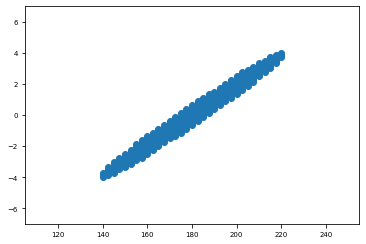

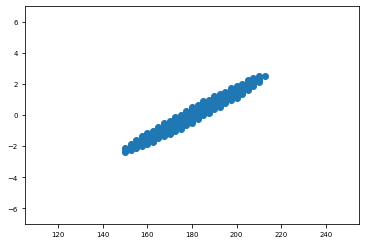

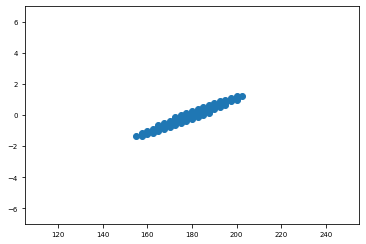

Cp ave: [12.93694276 16.14079195 22.14137775]


In [59]:
# Find average phase speed

# Only save the data that is bigger than 1.6
pr_strong = np.where( pr_kw_hovmoller>=1.6, pr_kw_hovmoller, np.nan)
Cp_ave = np.empty([3])
for icase in range(0,3):
    istrong = np.argwhere(np.isnan(pr_strong[:,:,icase])==0).squeeze()
    itlag_strong = istrong[:,0] 
    ilon_strong  = istrong[:,1]

    plt.scatter(lon[ilon_strong], tlag[itlag_strong])
    plt.xlim([105,255])
    plt.ylim([-7,7])
    plt.show()
    
    # find regression slope
    regr = linear_model.LinearRegression()
    y = lon[ilon_strong]
    x = np.array( [ tlag[itlag_strong] ] ).transpose()
    regr.fit(x,y)
    
    # ynew = b0 + b1*x 
    b0 = regr.intercept_
    b1 = regr.coef_[0]
    
    Cp_ave[icase] = b1*111*1000/(24*60*60) #m/s

print('Cp ave:',Cp_ave)

In [63]:
# Save output:
np.savez(output_dir_all+'kw_zwnum_freq_Cp_ave_from_precip_lag_regression.npz',\
        Cp_ave=Cp_ave, freq_ave=freq_ave, zwnum_ave=zwnum_ave)

In [67]:
# Test loading output ok
data = np.load(output_dir_all+'kw_zwnum_freq_Cp_ave_from_precip_lag_regression.npz')
Cp_ave = data['Cp_ave']
freq_ave = data['freq_ave']
zwnum_ave = data['zwnum_ave']
print('Average period:',freq_ave)
print('Average zonal wavenum:',zwnum_ave)
print('Average phase speed:',Cp_ave)
print('Average equivalent depth:',Cp_ave**2/9.8)

Average period: [3.75 3.   2.5 ]
Average zonal wavenum: [9. 9. 8.]
Average phase speed: [12.93694276 16.14079195 22.14137775]
Average equivalent depth: [17.07800897 26.58420048 50.02455191]
